<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/13_poetry_model_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [5]:
#hide
from fastbook import *
from IPython.display import display,HTML

# Lorca Poem creator from scratch

In [11]:
!pip install tika

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for tika: filename=tika-1.24-py3-none-any.whl size=32893 sha256=0463e6d29cf558be10b4f8764f79b86ee5e0c312e0416d476bcd9836ce01c5f8
  Stored in directory: /root/.cache/pip/wheels/ec/2b/38/58ff05467a742e32f67f5d0de048fa046e764e2fbb25ac93f3
Successfully built tika


In [ ]:
from tika import parser # pip install tika

raw = parser.from_file('/content/gdrive/MyDrive/lorca/federico-garcc3ada-lorca-obras-completas.pdf')
print(raw['content'])

In [249]:
from fastai.text.all import *

In [250]:
txt = raw['content']; txt[:1000]

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nObras Completas\n\n\n\n\nAnnotation\n\nFederico\tGarcía\tLorca,\t uno\t de\t los\t poetas\tmás\t insignes\t de\t nuestra\t época,\t nació\t en\n1898,\t en\t Fuente\t Vaqueros\t (Granada)\t y\t murió\t fusilado\t por\t los\t rebeldes\t en\t 1936,\t al\ncomienzo\t de\t la\t Guerra\t Civil\t española.\t Desde\t que,\t en\t 1918,\t publicara\t su\t primer\t libro\nImpresiones\t y\t paisajes,\t escribió\t y\t publicó\t numerosas\t obras\t de\t poesía,\t drama\t y\t prosa,\nalgunas\tde\tlas\tcuales\tfueron\tinterrumpidas\tpor\tsu\tmuerte.\n\nEn\t esta\t recopilación\t de\t Obras\t Completas\t se\t han\t tomado\t como\t base\t las\t Obras\nCompletas\tde\tFederico\tGarcía\tLorca\tde\tla\tweb:\n\nhttp://www.culturandalucia.com/FEDERICO_GARCIA_LORCA/Federico_Garcia_Lorca_Obras.htm\n\nTambién\tse\than\ttenido\ten\tcuenta\tlos\tcontenidos\tsobre\tLorca\tde\tlos\tsitios:\thttp://fac-\nweb.spsu.edu,\thttp://www.

In [251]:
#tokens = txt.replace('\n',"")
tokens = txt.replace('[',"")
tokens = tokens.replace(']',"")
tokens = tokens.replace('(',"")
tokens = tokens.replace(')',"")
tokens = tokens.replace('.'," .")
tokens = tokens.replace(';'," ;")
tokens = tokens.replace(','," ,")
tokens[:1000]

'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nObras Completas\n\n\n\n\nAnnotation\n\nFederico\tGarcía\tLorca ,\t uno\t de\t los\t poetas\tmás\t insignes\t de\t nuestra\t época ,\t nació\t en\n1898 ,\t en\t Fuente\t Vaqueros\t Granada\t y\t murió\t fusilado\t por\t los\t rebeldes\t en\t 1936 ,\t al\ncomienzo\t de\t la\t Guerra\t Civil\t española .\t Desde\t que ,\t en\t 1918 ,\t publicara\t su\t primer\t libro\nImpresiones\t y\t paisajes ,\t escribió\t y\t publicó\t numerosas\t obras\t de\t poesía ,\t drama\t y\t prosa ,\nalgunas\tde\tlas\tcuales\tfueron\tinterrumpidas\tpor\tsu\tmuerte .\n\nEn\t esta\t recopilación\t de\t Obras\t Completas\t se\t han\t tomado\t como\t base\t las\t Obras\nCompletas\tde\tFederico\tGarcía\tLorca\tde\tla\tweb:\n\nhttp://www .culturandalucia .com/FEDERICO_GARCIA_LORCA/Federico_Garcia_Lorca_Obras .htm\n\nTambién\tse\than\ttenido\ten\tcuenta\tlos\tcontenidos\tsobre\tLorca\tde\tlos\tsitios:\thttp://fac-\nweb .spsu .edu

In [252]:
tokens = tokens.split()

In [253]:
vocab = L(*tokens).unique()
vocab


(#33913) ['Obras','Completas','Annotation','Federico','García','Lorca',',','uno','de','los'...]

In [254]:
seql = 40

In [255]:
word2idx = {w:i for i,w in enumerate(vocab)}
nums = L(word2idx[i] for i in tokens)
nums

(#340163) [0,1,2,3,4,5,6,7,8,9...]

In [256]:
seqs = L((tensor(nums[i:i+seql]), nums[i+seql]) for i in range(0,len(nums)-seql-1,seql))
seqs

(#8504) [(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  8, 13, 14,  6, 15, 16, 17,  6, 16, 18, 19, 20, 21, 22, 23, 24,  9, 25, 16, 26,  6, 27, 28,  8, 29, 30, 31]), 32),(tensor([32, 33, 34, 35,  6, 16, 36,  6, 37, 38, 39, 40, 41, 21, 42,  6, 43, 21, 44, 45, 46,  8, 47,  6, 48, 21, 49,  6, 50,  8, 51, 52, 53, 54, 24, 38, 55, 33, 56, 57]), 58),(tensor([58,  8,  0,  1, 59, 60, 61, 62, 63, 51,  0,  1,  8,  3,  4,  5,  8, 29, 64, 65, 66, 67, 68, 69, 59, 60, 70, 16, 71,  9, 72, 73,  5,  8,  9, 74, 75, 76, 77, 78]), 6),(tensor([  6,  65,  79,  80,  21,  65,  81,  82,  33,  83,  84,  85,  51,  46,  86,  21,  87,  16,  88,  89,  90,   6,  91,  62,  92,  93,  94,   8,  38,  55,   6,  95,  96,   8,  97,  98,  21,  99,
        100,  33]), 101),(tensor([101, 102, 103,  60, 104, 105, 106, 107,  51, 108, 109,  16, 110,   8,  29, 111,   8, 112,   3,   4,   5,   6, 113, 114,  21,   3,   4,   5,   6, 115, 116, 117, 118,   8, 119,   6, 120,   6,
        121,  33]), 65),(tensor([ 65,  66,  

In [257]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(seqs[:cut], seqs[cut:], bs=64, shuffle=False)

In [75]:
class LMModel2(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        
    def forward(self, x):
        h = 0
        for i in range(seql):
            h = h + self.i_h(x[:,i])
            h = F.relu(self.h_h(h))
        return self.h_o(h)

In [79]:
learn = Learner(dls, LMModel2(len(vocab), 32), loss_func=F.cross_entropy, 
                metrics=accuracy)
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.401573,8.359144,0.000000,00:00
1,8.297399,8.222700,0.000000,00:00
2,7.958394,30.237970,0.035714,00:00
3,8.121090,7.689475,0.035714,00:00
4,7.637074,7.614786,0.047619,00:00
5,7.235262,7.512228,0.047619,00:00
6,6.864734,7.440926,0.047619,00:00
7,6.522115,7.421534,0.047619,00:00
8,6.219722,7.430132,0.047619,00:00
9,5.967547,7.433140,0.047619,00:00


In [85]:
class LMModel3(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        for i in range(seql):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
        out = self.h_o(self.h)
        self.h = self.h.detach()
        return out
    
    def reset(self): self.h = 0

In [81]:
m = len(seqs)//bs
m,bs,len(seqs)

(6, 64, 417)

In [82]:
def group_chunks(ds, bs):
    m = len(ds) // bs
    new_ds = L()
    for i in range(m): new_ds += L(ds[i + m*j] for j in range(bs))
    return new_ds

In [83]:
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs), 
    group_chunks(seqs[cut:], bs), 
    bs=bs, drop_last=True, shuffle=False)

In [84]:
learn = Learner(dls, LMModel3(len(vocab), 64), loss_func=F.cross_entropy,
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(10, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,8.349112,8.313526,0.000000,00:00
1,8.295486,8.237252,0.000000,00:00
2,8.167057,8.065930,0.015625,00:00
3,7.870379,8.509933,0.031250,00:00
4,7.218310,8.209124,0.062500,00:00
5,6.662850,7.678238,0.093750,00:00
6,6.208212,8.232747,0.078125,00:00
7,5.832365,8.113040,0.093750,00:00
8,5.527820,8.496554,0.093750,00:00
9,5.280161,8.605272,0.093750,00:00


In [142]:
sl = 40
seqs = L((tensor(nums[i:i+sl]), tensor(nums[i+1:i+sl+1]))
         for i in range(0,len(nums)-sl-1,sl))
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(group_chunks(seqs[:cut], bs),
                             group_chunks(seqs[cut:], bs),
                             bs=bs, drop_last=True, shuffle=False)

In [87]:
class LMModel4(Module):
    def __init__(self, vocab_sz, n_hidden):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)  
        self.h_h = nn.Linear(n_hidden, n_hidden)     
        self.h_o = nn.Linear(n_hidden,vocab_sz)
        self.h = 0
        
    def forward(self, x):
        outs = []
        for i in range(sl):
            self.h = self.h + self.i_h(x[:,i])
            self.h = F.relu(self.h_h(self.h))
            outs.append(self.h_o(self.h))
        self.h = self.h.detach()
        return torch.stack(outs, dim=1)
    
    def reset(self): self.h = 0

In [88]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [90]:
learn = Learner(dls, LMModel4(len(vocab), 64), loss_func=loss_func,
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.334532,8.298872,0.000391,00:01
1,8.254466,8.053873,0.014453,00:01
2,14.621455,7.088810,0.035937,00:01
3,12.384159,7.435526,0.040234,00:01
4,11.029077,7.086061,0.029297,00:01
5,10.028005,6.987484,0.060938,00:01
6,9.261831,6.944528,0.063672,00:01
7,8.656482,6.945956,0.069141,00:01
8,8.163579,6.919015,0.071484,00:01
9,7.756437,6.956716,0.070312,00:01


In [91]:
class LMModel5(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.RNN(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = torch.zeros(n_layers, bs, n_hidden)
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(res)
    
    def reset(self): self.h.zero_()

In [92]:
learn = Learner(dls, LMModel5(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,8.346545,8.337866,0.000391,00:01
1,8.328381,8.286561,0.000391,00:01
2,8.271790,8.035854,0.049219,00:01
3,8.080894,7.346517,0.064453,00:01
4,7.779276,6.876366,0.050781,00:01
5,7.493887,6.804914,0.051562,00:01
6,7.278198,6.879838,0.054297,00:01
7,7.117814,6.931529,0.050000,00:01
8,6.991854,6.957365,0.050000,00:01
9,6.890099,6.977496,0.049219,00:01


In [93]:
class LMModel6(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [94]:
learn = Learner(dls, LMModel6(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,8.342263,8.332246,0.001563,00:01
1,8.318126,8.207052,0.016016,00:01
2,8.074806,7.034512,0.017188,00:01
3,7.637185,7.098006,0.052734,00:01
4,7.352601,7.232337,0.053516,00:01
5,7.147218,7.363180,0.048828,00:01
6,6.996726,7.406292,0.050781,00:01
7,6.882939,7.430689,0.053125,00:01
8,6.793693,7.451829,0.048047,00:01
9,6.722270,7.464892,0.048828,00:01


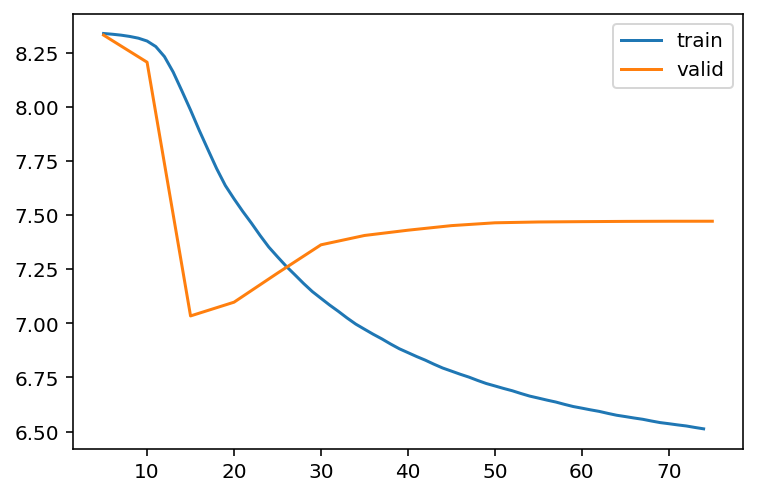

In [95]:
learn.recorder.plot_loss()

In [96]:
class Dropout(Module):
    def __init__(self, p): self.p = p
    def forward(self, x):
        if not self.training: return x
        mask = x.new(*x.shape).bernoulli_(1-p)
        return x * mask.div_(1-p)

In [97]:
class LMModel7(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers, p):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.drop = nn.Dropout(p)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h_o.weight = self.i_h.weight
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        raw,h = self.rnn(self.i_h(x), self.h)
        out = self.drop(raw)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(out),raw,out
    
    def reset(self): 
        for h in self.h: h.zero_()

In [146]:
learn = Learner(dls, LMModel7(len(vocab), 64, 2, 0.5),
                loss_func=CrossEntropyLossFlat(), metrics=accuracy,
                cbs=[ModelResetter, RNNRegularizer(alpha=2, beta=1)])

In [145]:
learn.fit_one_cycle(25, 3e-3, wd=0.1)

epoch,train_loss,valid_loss,accuracy,time


AttributeError: ignored

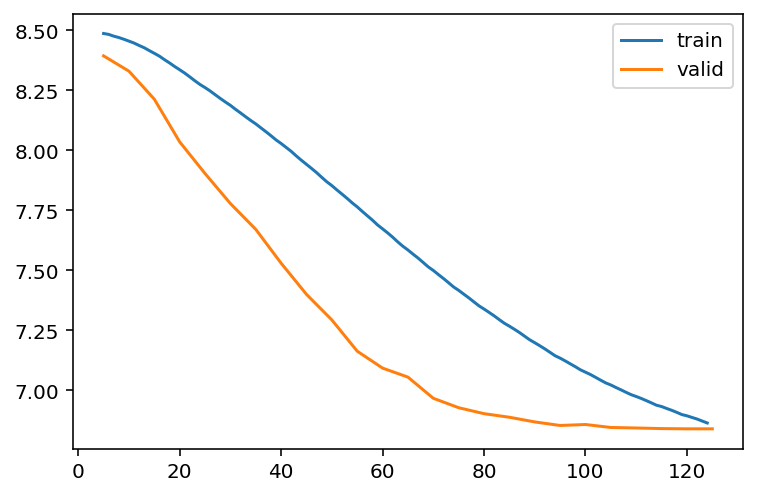

In [135]:
learn.recorder.plot_loss()

In [258]:
df = pd.DataFrame({'col':tokens})

In [259]:
df = pd.DataFrame([sub.split(";") for sub in [' '.join(tokens)]])

In [260]:
df = df.transpose()


In [262]:
df['text2'] = 0

In [263]:
df.columns = ['text', 'textfalse']

In [264]:
dls_lm = DataBlock(
    blocks=TextBlock.from_df('text', is_lm=True),get_x=ColReader('text'),splitter=RandomSplitter(0.2))

dls_lm = dls_lm.dataloaders(df, bs=40)
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos no soy xxunk de la xxmaj xxunk xxmaj xxunk . xxup tío xxmaj cada uno vive como puede o como sabe en esta vida xxunk . xxup señor x xxmaj está entendido , la xxmaj tierra es un xxunk xxunk , pero hay que ayudar a la civilización . xxmaj si xxmaj santos xxmaj xxunk , en vez de estudiar xxmaj xxunk xxunk , se hubiera xxunk a cuidar rosas ,","no soy xxunk de la xxmaj xxunk xxmaj xxunk . xxup tío xxmaj cada uno vive como puede o como sabe en esta vida xxunk . xxup señor x xxmaj está entendido , la xxmaj tierra es un xxunk xxunk , pero hay que ayudar a la civilización . xxmaj si xxmaj santos xxmaj xxunk , en vez de estudiar xxmaj xxunk xxunk , se hubiera xxunk a cuidar rosas , el"
1,"rodeados de una belleza natural única , no esperan nada y sólo saben sonreír . xxmaj el viajero poco xxunk encontrará con la variación increíble de formas , de paisaje , de luz y de olor la sensación de que xxmaj granada es capital de un reino con arte y literatura propios , y xxunk una curiosa xxunk de la xxmaj granada judía y la xxmaj granada xxunk , xxunk fundidas por","de una belleza natural única , no esperan nada y sólo saben sonreír . xxmaj el viajero poco xxunk encontrará con la variación increíble de formas , de paisaje , de luz y de olor la sensación de que xxmaj granada es capital de un reino con arte y literatura propios , y xxunk una curiosa xxunk de la xxmaj granada judía y la xxmaj granada xxunk , xxunk fundidas por el"


In [265]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [266]:
learn.fit_one_cycle(100,1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,7.148681,7.026443,0.100724,1126.018799,00:14
1,6.909768,6.752982,0.105498,856.609070,00:14
2,6.649330,6.472504,0.114468,647.101807,00:14
3,6.352115,6.176492,0.126525,481.300446,00:14
4,6.076687,5.882262,0.139444,358.619598,00:14
5,5.795281,5.637851,0.150013,280.858429,00:14
6,5.584991,5.477872,0.157241,239.336823,00:14
7,5.440235,5.372392,0.164910,215.377365,00:14
8,5.333639,5.282372,0.173768,196.836304,00:14
9,5.230339,5.195711,0.182910,180.496460,00:15


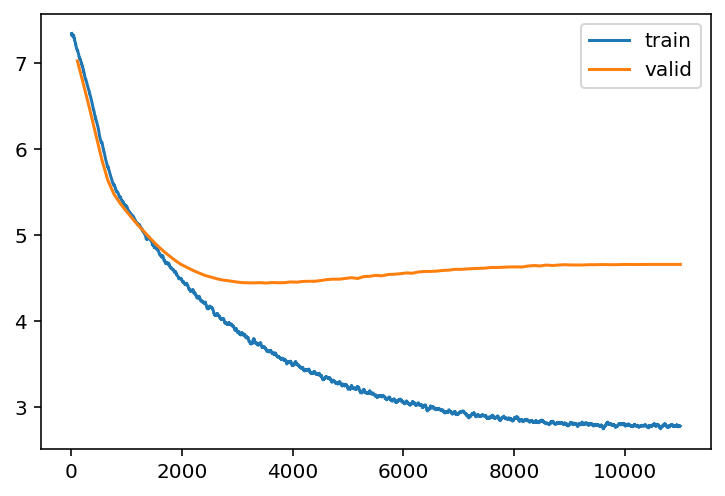

In [267]:
learn.recorder.plot_loss()

In [282]:
TEXT = 'Viva el mar, las estrellas. Los horizontes infinitos y la lluvia suave.' 
N_WORDS = 40
N_SENTENCES = 5
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
preds

['Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Hoy perfume y de nardos , lengua comen , tú sabes que rompe una columna . El mar día . Nadie en el mundo . Cuando no se clavan inmensa tierra de tierra tierra .',
 'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Agua y espuma , y ceniza de ceniza . Hoy musgo sobre las ondas estrellas . Agua sobre las olas . Agua estancada a los álamos . Fuente de la seda negra . Agua',
 'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . No es posible que no florecieron . Pero no la ciudad se va y cuando el aire tú no me gusta más que el mar . No lo extraño que te gusta . y no quiero decir',
 'Viva el mar , las estrellas . Los horizontes infinitos y la lluvia suave . Profundo y profundo , profundo y profundo , pero un frescor de enagua . Profundo y profundo , profundo , profundo , profundo , profundo y profundo , sin que profundo , profundo , profundo , profundo ,',
 'Viva el

In [246]:
preds

['Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . Un OTOÑO en la gran sombra de la vientos . La Muerte Satán el alma del árbol . Doña Muerte , La Muerte Un Campo De Cristo',
 'Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . CANCION DIJO Rojo Un un viejo claras de la luz , y un ciencia de los silencio . Las estrellas y un campo de plata marchita . Un fondo de niebla de horas con',
 'Un xxunk tembloroso xxunk las xxunk , y las arañas xxunk sus caminos de seda . Un aire en un amor y la luna que el que una mañana por la fuente del bosque de los años cadencia , y los niños y y los campos y inmortal ! Los árboles donde los mares']